In [83]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
import seaborn as sns

import warnings

warnings.filterwarnings('ignore')

A multivariate normal distribution is defined by its pdf: 
$$f(x) = \frac{1}{\sqrt{2\pi^d|\Sigma|}}e^{\frac{-1}{2}(x - \mu)^T\Sigma^{-1}(x - \mu)}$$
where $d$ is the number of dimensions of the distribution (the number of means), $\mu$ is the vector of means, and $\Sigma$ is the covariance matrix (and $|\Sigma| = det(\Sigma)$ ).

<hr>

From here we know a bivariate normal distribution is just a special case of the mutlivariate where $d = 2$. So the pdf of a bivariate normal distribution is: 
$$f(x) = \frac{1}{2\pi \sqrt{|\Sigma|}}e^{\frac{-1}{2}(x - \mu)^T\Sigma^{-1}(x - \mu)}$$

<hr>

We'll draw 100 points from the bivariate distribution and get the correlation $\hat{\rho}_{100}$ between the two variables

In [84]:
mus = np.array([1, -1])
cov = np.array([[0.8, 0.5], [0.5, 0.4]])

X = np.random.multivariate_normal(mus, cov, size=100)
X[:5]

array([[ 0.80357182, -0.99017527],
       [ 1.13399791, -1.08262965],
       [ 0.98348784, -0.96369956],
       [ 1.81255331, -1.0540456 ],
       [ 1.84995325, -1.39459354]])

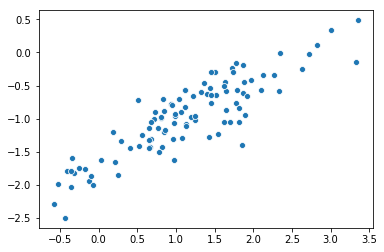

In [85]:
sns.scatterplot(X[:,0], X[:,1]);

In [86]:
corr, p_val = stats.pearsonr(X[:,0], X[:,1])
corr

0.8794937516652724

We'll repeat this process 1000 times of drawing 100 points and getting the pearson correlation. We will then draw a histogram of the correlations.

In [87]:
corrs = []
for i in range(1_000):
    X = np.random.multivariate_normal(mus, cov, size=100)
    corr, p_val = stats.pearsonr(X[:,0], X[:,1])
    corrs.append(corr)

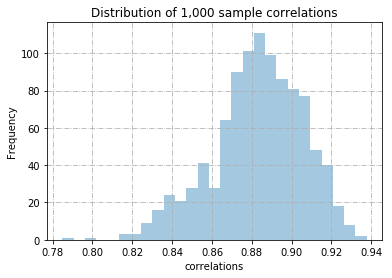

In [88]:
sns.distplot(corrs, kde=False)
plt.title('Distribution of 1,000 sample correlations');
plt.xlabel('correlations')
plt.ylabel('Frequency')
plt.grid(linestyle='-.')

You can see that the distribution of sample correlations is __almost__ normal but not quite. This isn't a coincidence and we can see this effect if we sample more correlations. For example we'll sample 10_000.

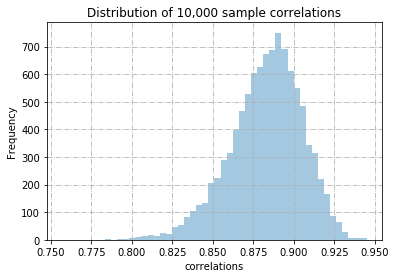

In [100]:
corrs = []
for i in range(10_000):
    X = np.random.multivariate_normal(mus, cov, size=100)
    corr, p_val = stats.pearsonr(X[:,0], X[:,1])
    corrs.append(corr)

corrs = np.array(corrs)
sns.distplot(corrs, kde=False)
plt.title('Distribution of 10,000 sample correlations');
plt.xlabel('correlations')
plt.ylabel('Frequency')
plt.grid(linestyle='-.')

# The Fisher Transform

$$F(r) = \frac{1}{2}\ln(\frac{1+r}{1-r})$$

The fisher transform says that if we start with random variables $(X,Y)$ that are close to bivariate normal then $F(\hat{\rho}_n)$, for independent and identically distributed (i.i.d.) sampling, is normally distributed with mean $F(\rho = \frac{cov(X,Y)}{\sqrt{V(X)V(Y)}})$ and a standard deviation of $\frac{1}{\sqrt{n-3}}$.

This means that we can convert our almost normal distribution of correlations to a normal distribution.

In [101]:
# note np.log is the natural logarithm
def fisher(r):
    return 0.5 * np.log((1+r) / (1-r))

In [102]:
fisher_corrs = fisher(corrs)
fisher_corrs

array([1.56204007, 1.37893107, 1.31389201, ..., 1.47169332, 1.2881681 ,
       1.35186501])

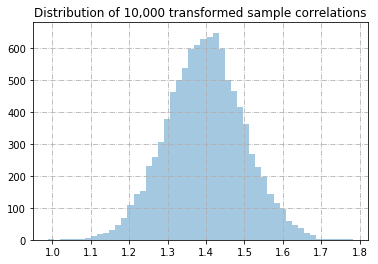

In [103]:
sns.distplot(fisher_corrs, kde=False)
plt.title('Distribution of 10,000 transformed sample correlations');
plt.grid(linestyle='-.')

We can see that this distribution looks much more normal then the one of just the sampling correlations above. 

Now let's check the mean and standard deviation. According to Fisher the mean should be $F(\rho = \frac{cov(X,Y)}{\sqrt{V(X)V(Y)}})$ and the standard deviation should be $\frac{1}{\sqrt{n-3}}$.

In [108]:
# Remember the Covariance matrix contains the variance of each variable along the diagonal
# and the covariance between each variable everywhere else. 
rho = cov[0,1] / np.sqrt(cov[0,0] * cov[1,1])

fisher_mean = fisher(rho)
empirical_mean = fisher_corrs.mean()

fisher_mean, empirical_mean

(1.393248202113216, 1.3973446310767914)

In [116]:
fisher_std = 1 / np.sqrt(len(fisher_corrs) - 3)
empirical_std = fisher_corrs.std()

fisher_std, empirical_std

(0.010001500337584396, 0.10054426091195742)

Everything seems to check out! Both the means and standard deviations are relativley close to the ones calculated through Fisher's theorem so we can now use this normal distribution we just found to calculate things like confidence intervals for $\rho$ and such.